In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn            import preprocessing 
from sklearn.metrics    import mean_squared_error
from sklearn.neighbors  import KNeighborsRegressor

from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender

In [19]:
pdf = pd.read_csv("../../data/daily/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

scaler = preprocessing.MinMaxScaler()
#pdf["y"] = scaler.fit_transform((pdf["Value_NE5"].values + pdf["Value_NE7"].values).reshape(-1, 1))
#pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

pdf["y"] = scaler.fit_transform((pdf["NE7_GWh"].values).reshape(-1, 1))
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

#split data in train val and test
#2657/365/(days since first december last year) 
# calculate the number of days from the last datapoint to the 1st of December 2022
n_test = (pdf.index[-1] -pd.to_datetime("2022-11-30")).days

split = len(pdf)-365-n_test
pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+365], pdf.iloc[split+365:]

In [20]:

#regressor = KNeighborsRegressor(n_neighbors=1)

forecaster = TransformedTargetForecaster(
    [
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("deseasonalize", Deseasonalizer(model="additive", sp=7)),
        ("deseasonalize", Deseasonalizer(model="additive", sp=365)),
        ("forecast", ARIMA() )  
        #("forecast", regressor )
    ]
)

# forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

y_train = pdf_train['y'].squeeze().asfreq(freq='D')
forecaster.fit(y_train)
horizon = ForecastingHorizon(pdf_test.index, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)


In [21]:
#use validation set to improve model. 

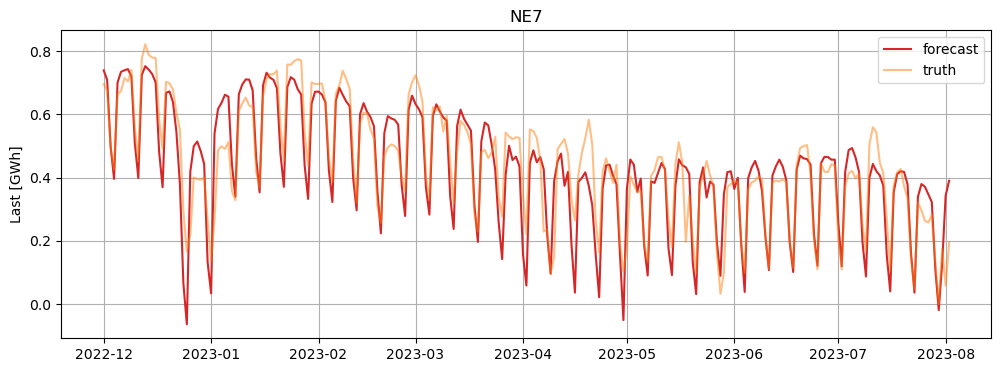

In [23]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))


axes.plot(y_pred, color="tab:red", label="forecast")
# axes.plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes.plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()

# xmin, xmax = axes[0].get_xlim()
# axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values)*100) # / (pdf_test.y.values+y_pred.values)*100)
# axes[1].set_xlim(xmin, xmax)
# axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

In [24]:
print(f"RMSE: {mean_squared_error(y_pred, pdf_test.y.values, squared=False)}")


RMSE: 0.08435496936600156


### Better apply monthly Aggregation or directly train on Monthly? 

In [25]:
prediction = pd.DataFrame(scaler.inverse_transform((y_pred.values).reshape(-1, 1)).flatten(), columns=['y'])
prediction.index = y_pred.index

test = pd.DataFrame(scaler.inverse_transform((pdf_test.values).reshape(-1, 1)).flatten(), columns=['y'])
test.index = y_pred.index

In [29]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """
  pdf = pdf.resample(frequency.upper()).sum(min_count=1) #"D,W,M"
  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
  return pdf

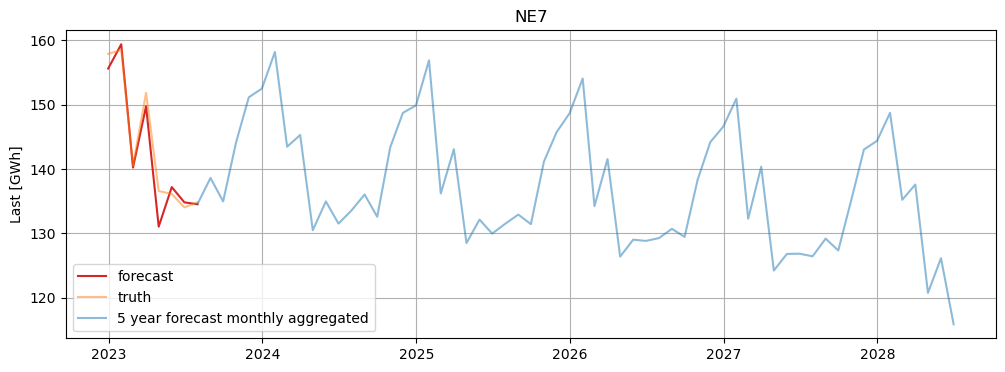

In [30]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

prediction  = resample_fix_ends(prediction, "M")
test        = resample_fix_ends(test, "M")
axes.plot(prediction, color="tab:red", label="forecast")
axes.plot(test, color="tab:orange", label="truth", alpha=0.5)

#create datetimerange from first of july 2023 to + 5 years
fiveyears = pd.date_range("2023-07-01", periods=365*5, freq="D")
horizon = ForecastingHorizon(fiveyears, is_relative=False)
fiveYearPrediction  = forecaster.predict(fh=horizon)

fiveYearPrediction = pd.DataFrame(scaler.inverse_transform(fiveYearPrediction.values.reshape(-1,1)).flatten(), index=fiveYearPrediction.index, columns=["y"])
axes.plot(resample_fix_ends(fiveYearPrediction, "M"), color="tab:blue", label="5 year forecast monthly aggregated", alpha=0.5)
# axes.plot(fiveYearPrediction/4e6, color="tab:green", label="5 year forecast daily", alpha=0.5)
# axes.plot(prediction.resample("M").sum(min_count=1), color="tab:blue", label="forecast",alpha=0.5)
# axes.plot(test.resample("M").sum(min_count=1), color="tab:green", label="truth", alpha=0.5)
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()

plt.show()

In [31]:
print(f"RMSE: {mean_squared_error(prediction.y.values, test.y.values, squared=False)}")

RMSE: 2.3121329517568827


In [32]:
# Train on montly
pdf_train = resample_fix_ends(pdf_train, "M")
pdf_val   = resample_fix_ends(pdf_val, "M")
pdf_test  = resample_fix_ends(pdf_test, "M")

In [33]:

forecaster = TransformedTargetForecaster(
    [
        # ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        # ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
        ("forecast", ARIMA() )  
        #("forecast", regressor )
    ]
)


idx = pd.period_range(start=pdf_train.index[0], end= pdf_train.index[-1], freq="M")
y_train = pd.Series(pdf_train.y.values, index=idx)

forecaster.fit(y_train)


TransformedTargetForecaster(steps=[('forecast', ARIMA())])

In [34]:
idx = pd.period_range(start=pdf_test.index[0], end= pdf_test.index[-1], freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)
y_pred

2022-12    17.079871
2023-01    17.056666
2023-02    17.038465
2023-03    17.024189
2023-04    17.012992
2023-05    17.004210
2023-06    16.997321
2023-07    16.991918
Freq: M, dtype: float64

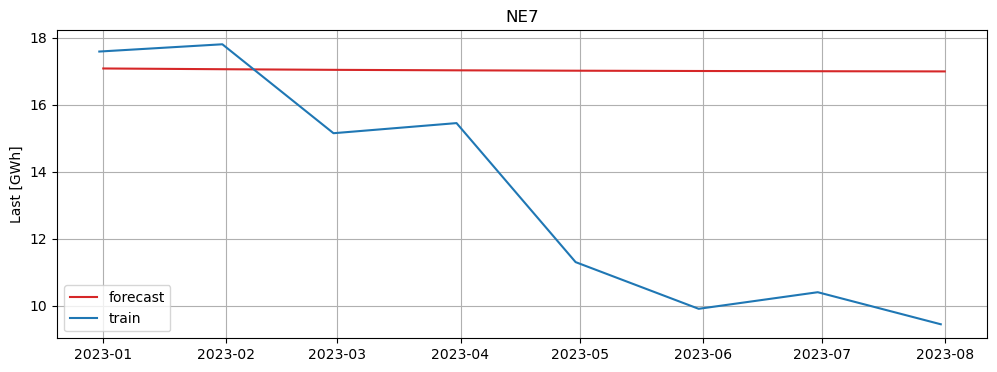

In [35]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(y_pred.index.to_timestamp(how="end"), y_pred.values, color="tab:red", label="forecast")
axes.plot(pdf_test, color="tab:blue", label="train")
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()
plt.show()

In [36]:
print(f"RMSE: {mean_squared_error(y_pred.values, pdf_test.values, squared=False)}")

RMSE: 4.877325807217233


In [37]:
# Debugging/Test Code

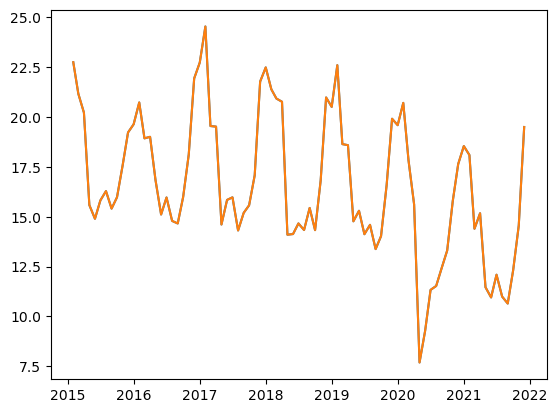

In [38]:
#How can i plot the individual components of the model?
plt.plot(forecaster.transform(pdf_train['y']))
plt.plot(pdf_train['y'])